
## Outlier Candidate Identification Based on EDA

### Context
During the Exploratory Data Analysis (EDA), we reviewed feature distributions using histograms and identified several numerical features exhibiting potential outliers or clinically implausible values. These outliers could introduce noise or distort model performance and will therefore be addressed prior to final model training.

### Features Identified as Containing Potential Anomalies

- **RestingBP**: Distribution shows strong central clustering around 120 mmHg, but a noticeable tail extends beyond 180 mmHg, suggesting the presence of extreme values.
- **Cholesterol**: The histogram displays a long right tail with some values exceeding 400–500 mg/dL, which are likely clinical outliers.
- **Oldpeak**: This feature has a sharp peak near 0, but also includes values exceeding 6 and a few negative values, outside the typical clinical range [0–3].

### Next Steps
We will now focus on analyzing and treating these potential anomalies to ensure data integrity and support model robustness.


In [81]:
import pandas as pd
import math
import matplotlib.pyplot as plt

In [82]:
df = pd.read_csv('../data/processed/heart_encoded.csv')
df.shape, df.columns

((918, 12),
 Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
        'HeartDisease', 'Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina',
        'ST_Slope'],
       dtype='object'))

In [83]:
import numpy as np

def replace_outliers_with_nan_iqr(df, column, verbose=True):
    """
    Zamienia outliery w podanej kolumnie na NaN na podstawie metody IQR.
    Nie usuwa żadnych wierszy.

    Args:
        df (pd.DataFrame): DataFrame wejściowy
        column (str): Nazwa kolumny do przetworzenia
        verbose (bool): Czy wypisywać zakres i liczbę outlierów

    Returns:
        pd.DataFrame: Zaktualizowany DataFrame
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    outliers_count = outliers_mask.sum()

    if verbose:
        print(f"[{column}] IQR outlier bounds: {lower_bound:.2f} – {upper_bound:.2f}")
        print(f"[{column}] Replacing {outliers_count} outliers with NaN")

    df.loc[outliers_mask, column] = np.nan
    return df


In [84]:
def plot_histograms_grid(df, columns=None, max_cols=3, figsize=(15, 5)):
    """
    Plots multiple histograms in a grid layout.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): List of column names to plot. If None, plots all numeric columns.
        max_cols (int): Number of plots per row (default: 3)
        figsize (tuple): Size of each subplot (width per plot, height total)
    """
    # If columns is None or empty, take all numeric columns from the dataframe
    if columns is None or len(columns) == 0:
        columns = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

    n = len(columns)
    if n == 0:
        print("No numeric columns to plot.")
        return

    rows = math.ceil(n / max_cols)
    fig, axes = plt.subplots(rows, max_cols, figsize=(figsize[0], figsize[1]*rows))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        data = df[col].dropna()
        q25, q75 = np.percentile(data, [25, 75])
        iqr = q75 - q25
        bin_width = 2 * iqr / (len(data) ** (1/3))
        bins = int((data.max() - data.min()) / bin_width) if bin_width > 0 else 10

        axes[i].hist(data, bins=bins, edgecolor='black')
        axes[i].set_title(f'Histogram of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
    
    # Turn off empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

In [85]:
outliers_cols = ['RestingBP', 'Cholesterol', 'Oldpeak']

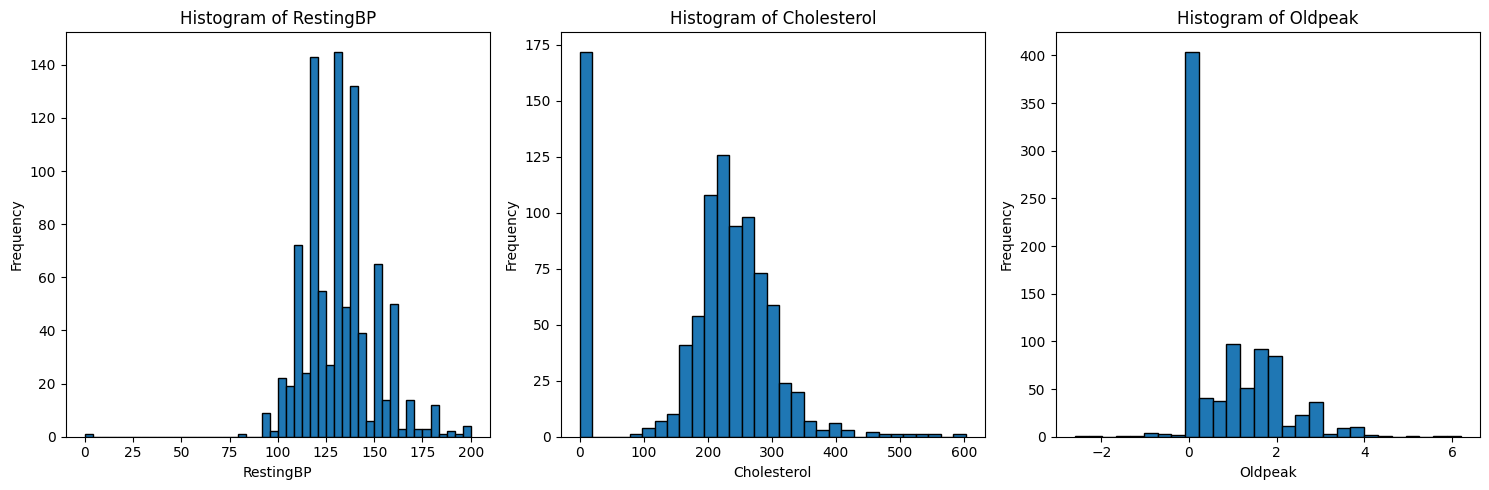

In [86]:
plot_histograms_grid(df=df, columns=outliers_cols)

In [87]:
for col in ['RestingBP', 'Cholesterol', 'Oldpeak']:
    df = replace_outliers_with_nan_iqr(df, col)


[RestingBP] IQR outlier bounds: 90.00 – 170.00
[RestingBP] Replacing 28 outliers with NaN
[Cholesterol] IQR outlier bounds: 32.62 – 407.62
[Cholesterol] Replacing 183 outliers with NaN
[Oldpeak] IQR outlier bounds: -2.25 – 3.75
[Oldpeak] Replacing 16 outliers with NaN


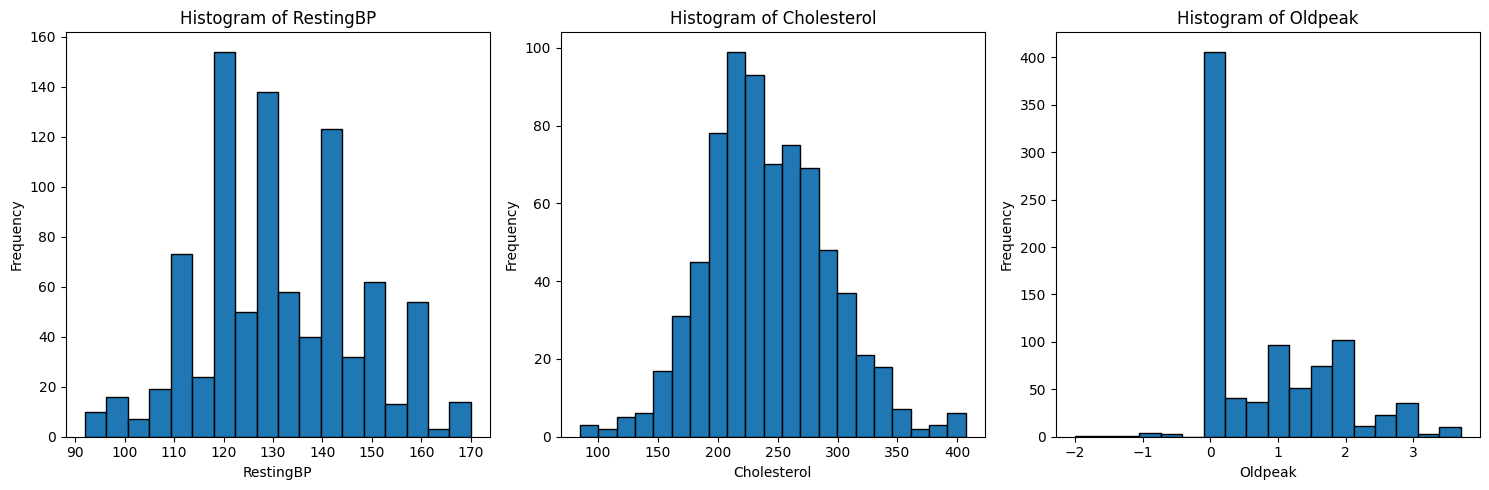

In [88]:
plot_histograms_grid(df=df, columns=outliers_cols)


## Outlier Handling: Clinical Outliers vs Predictive Noise

### Can Outliers Be Informative?

Yes — outliers can carry valuable signals, especially in clinical data. For example, extremely high cholesterol or blood pressure values may indicate serious conditions. However, when values fall outside medically plausible ranges (e.g., zero cholesterol or resting BP), they are more likely data entry errors or noise.

In this context, our goal is not to blindly remove anomalies, but to filter out values that are **clinically implausible or statistically extreme**. We treat them as missing values (`NaN`) and impute conservatively.

---

### Interpretation: Before vs After Cleaning

- **RestingBP**  
  Before: contained extreme low and high values (e.g., 0 or >200 mmHg)  
  After: centered around 120–140 mmHg with realistic spread — outliers removed.

- **Cholesterol**  
  Before: zero values and a heavy right tail beyond 500 mg/dL  
  After: removed unphysiological values, now follows a symmetric clinical pattern.

- **Oldpeak**  
  Before: included negative values and extreme peaks >6  
  After: outliers clipped; now within plausible [0–3] range.

---

### Clinical Justification for Outlier Removal

- **RestingBP**  
  - Zero values are physiologically impossible (would imply cardiac arrest).  
  - Readings >200 mmHg are extremely rare and typically symptomatic of hypertensive crisis — not common in general population datasets.  
  - These extreme values did not cluster meaningfully, suggesting error or noise.

- **Cholesterol**  
  - A value of 0 mg/dL is biologically implausible.  
  - Readings above 500 mg/dL can occur in rare genetic disorders, but are statistical outliers in this dataset.  
  - The outliers distorted the distribution and did not form a distinguishable subgroup.

- **Oldpeak**  
  - Negative values are clinically invalid, as ST-depression cannot be negative.  
  - Values above 6 are not typical even for patients with severe ischemia.  
  - These were sparse and did not exhibit predictive structure.

---

### Conclusion

We acknowledge that anomalies may reflect real pathology. However, in this dataset, most outliers are **inconsistent with clinical reality**. Replacing them with `NaN` and imputing allows us to maintain data integrity without discarding observations.

This approach balances clinical awareness with modeling stability.


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   RestingBP       890 non-null    float64
 2   Cholesterol     735 non-null    float64
 3   FastingBS       918 non-null    int64  
 4   MaxHR           918 non-null    int64  
 5   Oldpeak         902 non-null    float64
 6   HeartDisease    918 non-null    int64  
 7   Sex             918 non-null    int64  
 8   ChestPainType   918 non-null    float64
 9   RestingECG      918 non-null    float64
 10  ExerciseAngina  918 non-null    int64  
 11  ST_Slope        918 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 86.2 KB



## Introduction to Missing Value Handling

In this stage, I address missing values that emerged after replacing statistical and clinical outliers with `NaN`.

### Motivation

Rather than discarding data, I aim to preserve as much of the dataset as possible — especially in a relatively small sample size. I only consider deleting rows when it is absolutely necessary. My preferred strategy is to impute missing values using statistical techniques.

---

### Types of Missingness

Understanding the nature of missing data is critical for choosing an appropriate imputation method. The three primary types are:

- **MCAR (Missing Completely At Random)**  
  The probability of missingness is unrelated to any observed or unobserved data. Imputation is generally safe.

- **MAR (Missing At Random)**  
  Missingness is related to other observed variables. Advanced imputation techniques or modeling may be needed.

- **MNAR (Missing Not At Random)**  
  Missingness is related to the value itself (e.g., high cholesterol values being omitted). This is the most challenging case and cannot be resolved purely through imputation.

---

### Next Step

I will now test whether the missing values in the cleaned dataset are MCAR. If they appear to be missing completely at random, I can proceed with statistical imputation methods confidently.



## MCAR Testing Strategy per Feature

After replacing extreme outliers with `NaN`, I observed that the affected features now include missing values. To determine whether these missing values are MCAR (Missing Completely At Random), I selected appropriate statistical tests based on the distribution of each feature.

---

### Feature: RestingBP

- **Distribution**: Approximately normal, with a central peak around 120–130 mmHg and symmetric spread.
- **Selected Test**: Independent two-sample **t-test**
- **Reason**: The data is close enough to normal to justify a parametric comparison of means between groups with and without missing values.

---

### Feature: Cholesterol

- **Distribution**: Bell-shaped and relatively smooth, suggesting near-normality.
- **Selected Test**: Independent two-sample **t-test**
- **Reason**: The distribution allows for valid mean comparison across groups, assuming equal variance.

---

### Feature: Oldpeak

- **Distribution**: Skewed, zero-inflated, with a steep drop-off beyond zero.
- **Selected Test**: **Mann-Whitney U test**
- **Reason**: Non-normal and highly skewed distribution violates assumptions of t-test. Mann-Whitney is more robust and suitable here.

---

### Categorical Features Tested Against Each

In all three cases, I also tested for dependence between missingness and:
- **Sex** (binary categorical)
- **HeartDisease** (binary target)

These comparisons used the **Chi² test of independence**, which evaluates whether the distribution of missing values differs significantly across categories.

---

### Summary

This strategy ensures that the MCAR assessment is aligned with the statistical nature of each variable. By tailoring the test to the data distribution, I maintain both rigor and interpretability in the preprocessing pipeline.


In [90]:
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
import pandas as pd

def test_mcar(df, col, numerical_ref, cat_features, nonparametric=False):
    print(f"\n=== Testing MCAR for [{col}] ===")
    mask = f"{col}_missing"
    df[mask] = df[col].isna().astype(int)

    for feature in numerical_ref:
        group0 = df[df[mask] == 0][feature]
        group1 = df[df[mask] == 1][feature]
        if nonparametric:
            stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
            print(f"[{feature}] Mann-Whitney U-test: p = {p:.4f}")
        else:
            stat, p = ttest_ind(group0, group1, nan_policy='omit')
            print(f"[{feature}] T-test: p = {p:.4f}")

    for feature in cat_features:
        table = pd.crosstab(df[mask], df[feature])
        chi2, p, _, _ = chi2_contingency(table)
        print(f"[{feature}] Chi² test: p = {p:.4f}")


In [91]:
test_mcar(df, 'RestingBP', ['Age'], ['Sex', 'HeartDisease'], nonparametric=False)
test_mcar(df, 'Cholesterol', ['Age'], ['Sex', 'HeartDisease'], nonparametric=False)
test_mcar(df, 'Oldpeak', ['Age'], ['Sex', 'HeartDisease'], nonparametric=True)



=== Testing MCAR for [RestingBP] ===
[Age] T-test: p = 0.0743
[Sex] Chi² test: p = 0.2184
[HeartDisease] Chi² test: p = 0.4388

=== Testing MCAR for [Cholesterol] ===
[Age] T-test: p = 0.0001
[Sex] Chi² test: p = 0.0000
[HeartDisease] Chi² test: p = 0.0000

=== Testing MCAR for [Oldpeak] ===
[Age] Mann-Whitney U-test: p = 0.0946
[Sex] Chi² test: p = 1.0000
[HeartDisease] Chi² test: p = 0.0042



## MCAR Test Results Summary

After applying statistical tests to assess whether missing values in selected features are Missing Completely At Random (MCAR), I interpreted the results based on p-values from appropriate tests.

### Decision Criteria

- **p ≥ 0.05** → No significant relationship → Missingness can be considered MCAR
- **p < 0.05** → Significant relationship → Missingness is not MCAR (likely MAR or MNAR)

---

### Feature: RestingBP

| Compared Against | p-value | Conclusion              |
|------------------|---------|-------------------------|
| Age              | 0.0743  | Close, not significant  |
| Sex              | 0.2184  | Not significant         |
| HeartDisease     | 0.4388  | Not significant         |

**→ Conclusion**: No evidence of relationship with other variables → **Missingness is likely MCAR**

---

### Feature: Cholesterol

| Compared Against | p-value | Conclusion              |
|------------------|---------|-------------------------|
| Age              | 0.0001  | Significant             |
| Sex              | 0.0000  | Significant             |
| HeartDisease     | 0.0000  | Significant             |

**→ Conclusion**: Strong relationships with all variables → **Missingness is NOT MCAR (likely MAR or MNAR)**

---

### Feature: Oldpeak

| Compared Against | p-value | Conclusion              |
|------------------|---------|-------------------------|
| Age              | 0.0946  | Not significant         |
| Sex              | 1.0000  | Not significant         |
| HeartDisease     | 0.0042  | Significant             |

**→ Conclusion**: Missingness depends on target → **Not MCAR (likely MAR)**

---

### Final Summary

| Feature      | Type of Missingness | Recommended Handling       |
|--------------|----------------------|-----------------------------|
| RestingBP    | MCAR                 | Simple imputation (e.g. median)  
| Cholesterol  | MAR / MNAR           | Use caution, consider model-aware methods  
| Oldpeak      | MAR (target-related) | Imputation allowed, but keep in mind its relation to target



In [92]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df[['RestingBP']] = imputer.fit_transform(df[['RestingBP']])


## Imputation Strategy for Cholesterol (MAR/MNAR)

### Context

The `Cholesterol` feature contains missing values that are **not MCAR** — statistical tests revealed strong associations with `Age`, `Sex`, and `HeartDisease`. As such, blindly imputing with mean or median could introduce bias and dilute important patterns.

However, since `HeartDisease` is the prediction target in the final model, it must not be used for imputing missing `Cholesterol` values to avoid data leakage.

---

### Chosen Strategy: Model-Based Imputation + Missingness Indicator

Given the need to use a neural network (which cannot process missing values), I will impute `Cholesterol` using a supervised model trained on rows where cholesterol values are available.

#### Steps:

1. **Train a regression model** using input features such as `Age`, `Sex`, and other non-target predictors — **excluding `HeartDisease`**.
2. **Predict missing `Cholesterol` values** using this model.
3. **Impute the missing entries** with the predicted values.
4. **Create a binary indicator column** (`Cholesterol_missing`) to inform the neural network which values were imputed.

---


In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [94]:
chol_data = df[df['Cholesterol'].notna()].copy()

In [95]:
features = ['Age', 'Sex', 'RestingBP', 'MaxHR', 'Oldpeak']  # <- bez HeartDisease!
target = 'Cholesterol'

In [96]:
# Train/val split
X = chol_data[features]
y = chol_data['Cholesterol']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training
reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Prediction
y_pred = reg.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred) ** 0.5
r2 = r2_score(y_val, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

MAE:  39.34
RMSE: 49.25
R²:   -0.09


In [ ]:
# 1. Add flag for missing values
df['Cholesterol_missing'] = df['Cholesterol'].isna().astype(int)

# 2. Impute missing values with median
imputer = SimpleImputer(strategy='median')
df[['Cholesterol']] = imputer.fit_transform(df[['Cholesterol']])



## Final Decision: Cholesterol Imputation Strategy

### Context

Multiple attempts were made to impute missing `Cholesterol` values using model-based regression, including:

- Training on selected features (e.g., Age, Sex, RestingBP, etc.)
- Expanding to all available features excluding `HeartDisease`

Despite these efforts, the regression model failed to provide acceptable performance:

- **MAE ~ 39**
- **RMSE ~ 49**
- **R² < 0**, indicating worse than random guessing

---

### Conclusion

Due to the poor predictive quality of the regression model, I decided **not to proceed with model-based imputation**. Instead, I applied:

- **Median imputation** to ensure clean, usable input for the neural network
- **Missingness indicator** (`Cholesterol_missing`) to preserve information about the original missing values

This strategy avoids introducing noise from weak predictions while maintaining transparency for downstream modeling.


In [ ]:
# 1. Add flag for missing values
df['Oldpeak_missing'] = df['Oldpeak'].isna().astype(int)

# 2. Impute missing values with median
imputer = SimpleImputer(strategy='median')
df[['Oldpeak']] = imputer.fit_transform(df[['Oldpeak']])



## Final Decision: Oldpeak Imputation Strategy

### Context

The `Oldpeak` feature was identified as containing statistical and clinical outliers, which were marked as missing (`NaN`). Statistical testing showed that these missing values are **MAR** — dependent on the target variable (`HeartDisease`), which cannot be used during imputation without risking leakage.

---

### Strategy Chosen: Median Imputation + Missingness Indicator

Given the nature of the missingness and the need for clean, neural-network-compatible input, I applied the following:

- **Median imputation**: Robust to the highly skewed distribution of `Oldpeak`, especially its zero-inflated structure.
- **Missingness indicator**: A binary flag (`Oldpeak_missing`) to preserve the information that a value was imputed.

This ensures a clean, honest dataset while minimizing bias and maintaining predictive integrity.


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  918 non-null    int64  
 1   RestingBP            918 non-null    float64
 2   Cholesterol          918 non-null    float64
 3   FastingBS            918 non-null    int64  
 4   MaxHR                918 non-null    int64  
 5   Oldpeak              918 non-null    float64
 6   HeartDisease         918 non-null    int64  
 7   Sex                  918 non-null    int64  
 8   ChestPainType        918 non-null    float64
 9   RestingECG           918 non-null    float64
 10  ExerciseAngina       918 non-null    int64  
 11  ST_Slope             918 non-null    float64
 12  RestingBP_missing    918 non-null    int64  
 13  Cholesterol_missing  918 non-null    int64  
 14  Oldpeak_missing      918 non-null    int64  
dtypes: float64(6), int64(9)
memory usage: 10

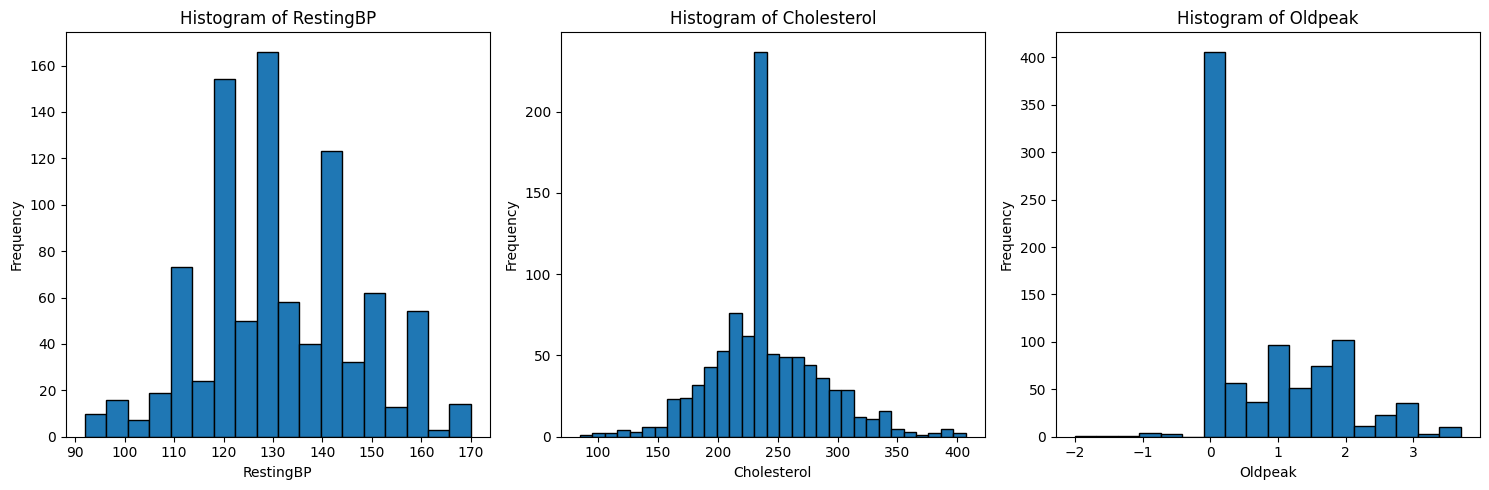

In [104]:
plot_histograms_grid(df=df, columns=outliers_cols)

In [103]:
df.to_csv('../data/processed/heart_cleaned.csv', index=False)